In [1]:
import sys
import os
import numpy as np
import time
from typing import Union, List, Sequence, Optional
from tqdm import trange

# Add the parent directory (project root) to sys.path
script_dir              = os.path.dirname(os.curdir)
parent_dir              = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.algebra.utils import JAX_AVAILABLE, get_backend
from QES.general_python.common.plot import Plotter
from QES.general_python.common.flog import Logger, get_global_logger

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices.lattice import LatticeBC, Lattice
from QES.general_python.lattices.honeycomb import HoneycombLattice
from QES.general_python.lattices.square import SquareLattice

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN

# ------------------------------------------------------------------
#! Hamiltonians
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev, HEI_KIT_Z_BOND_NEI, HEI_KIT_X_BOND_NEI, HEI_KIT_Y_BOND_NEI
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None

# ------------------------------------------------------------------
logger              = get_global_logger()
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

11_05_2025_20-12_51 [INFO] Log file created: ./log/QES_11_05_2025_20-12_51.log
11_05_2025_20-12_51 [INFO] Log level set to: info
11_05_2025_20-12_51 [INFO] ############Global logger initialized.############
11_05_2025_20-12_51 [INFO] JAX backend available and successfully imported
11_05_2025_20-12_51 [INFO] 	JAX 64-bit precision enabled.
11_05_2025_20-12_51 [INFO] Setting JAX as the active backend.
11_05_2025_20-12_51 [INFO] **************************************************
11_05_2025_20-12_51 [INFO] Backend Configuration:
11_05_2025_20-12_51 [INFO] 		NumPy Version: 2.1.3
11_05_2025_20-12_51 [INFO] 		SciPy Version: 1.15.2
11_05_2025_20-12_51 [INFO] 		JAX Version: 0.5.3
11_05_2025_20-12_51 [INFO] 		Active Backend: jax
11_05_2025_20-12_51 [INFO] 			JAX Available: True
11_05_2025_20-12_51 [INFO] 			Default Seed: 42
11_05_2025_20-12_51 [INFO] 		JAX Backend Details:
11_05_2025_20-12_51 [INFO] 				Main Module: jax.numpy
11_05_2025_20-12_51 [INFO] 				Random Module: jax.random (+ PRNGKey)
11

### Lattice interface

In [2]:
ham_dtype   = jnp.float64
lx          = 2
ly          = 3
# lattice     = SquareLattice(
#                     dim = 1, 
#                     lx  = lx,
#                     ly  = ly,
#                     lz  = 1, 
#                     bc  = LatticeBC.PBC
#                 )
lattice     = HoneycombLattice(
                    dim = 2,
                    lx  = lx,
                    ly  = ly,
                    lz  = 1,
                    bc  = LatticeBC.PBC
                )
ns          = lattice.ns
st_shape    = (ns, )

lattice

HON,LatticeBC.PBC,d=2,Ns=12,Lx=2,Ly=3,Lz=1

### Network - variational ansatz body $\psi _\theta (s)$ and its gradient $\nabla \psi _\theta (s)$.

In [3]:
net = RBM(
        input_shape     = st_shape, 
        n_hidden        = 2*ns,
        dtype           = dtypex,
        seed            = seed,
        visible_bias    = False,
        bias            = True
    )
net

11_05_2025_20-12_54 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
11_05_2025_20-12_54 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=312, is_holomorphic=True


ComplexRBM(shape=(12,), hidden=24, bias=on, visible_bias=off, dtype=complex128, params=312, analytic_grad=False, initialized)

### Sampler - sampling from the distribution $p_\theta (s)$.

In [4]:
n_chains        = 10
n_samples       = 100
n_therm_steps   = 25
sampler = Sampler.MCSampler(
                net             = net,
                shape           = st_shape,
                rng             = rng,
                rng_k           = rng_k,
                numchains       = n_chains,
                numsamples      = n_samples,
                sweep_steps     = ns,
                backend         = backend_np,
                therm_steps     = n_therm_steps,
                mu              = 2.0,
                seed            = seed
            )
sampler

MCSampler(shape=(12,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=12, numsamples=100, numchains=10, backend=jax)

### Hamiltonian - Hamiltonian operator $H$ and its expectation value $\langle H \rangle$.

In [5]:
model = 'kitaev'

if model == 'kitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.5,
                        hz              = -0.3,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 1.0,
                        dlt             = 1.0,
                        dtype           = jnp.float64,
                        backend         = backend)

else:
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hx             = 0.5,
                        hz             = -0.3,
                        dtype          = jnp.float64,
                        backend        = backend
                )
logger.title('Hamiltonian', desired_size=150, fill='#', color='red')

#######

if hamil.hilbert_size <= 2**12:
    hamil.build(use_numpy=True)
    hamil.diagonalize()
    eigv = hamil.get_eigval()
elif hamil.hilbert_size < 2**20:
    hamil.build(use_numpy=True)
    hamil.diagonalize(method = 'lanczos', k = 50)
    eigv = hamil.get_eigval()
else:
    eigv = None

11_05_2025_20-12_58 [INFO] 		->[Hamiltonian] The type of the lattice HON,LatticeBC.PBC,d=2,Ns=12,Lx=2,Ly=3,Lz=1 is not standard. Check your intentions...
11_05_2025_20-12_58 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier -0.3
11_05_2025_20-12_58 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 0.5
11_05_2025_20-12_58 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
11_05_2025_20-12_58 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
11_05_2025_20-12_58 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator 

ValueError: Failed to build the Hamiltonian matrix. Ensure all operators and spaces are properly set. : Failed in nopython mode pipeline (step: Literal propagation)
[1mFailed in literal_propagation_subpipeline mode pipeline (step: performs partial type inference)
[1m[1mUntyped global name '_op_f_mod_nosites':[0m [1mCannot type empty list
[1m
File "../QES/Algebra/Hamil/hamil_energy.py", line 209:[0m
[1m    def wrapper(k_map, i):
        <source elided>
        op_m_mod_nosites_i    = _op_m_mod_nosites_nb[i]
[1m        op_f_mod_nosites_i    = _op_f_mod_nosites[i] if hasattr(op_m_mod_nosites_i, '__len__') and len(op_m_mod_nosites_i) > 0 else None
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: Pass partial_type_inference[0m
[0m[1mDuring: Pass LiteralPropagation[0m

#### Plot if needed

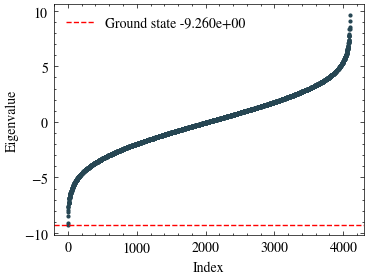

In [4]:
if eigv is not None:
    fig, ax = Plotter.get_subplots(
        nrows       = 1,
        ncols       = 1,
        figsize     = (4, 3),
        dpi         = 100,
    )
    x   = np.arange(0, len(eigv))
    y   = eigv
    ax[0].plot(x, y, 'o', markersize=2)
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Eigenvalue')
    ax[0].axhline(eigv[0], color='r', linestyle='--', label=f'Ground state {eigv[0]:.3e}')
    ax[0].legend()

### NQS - neural network quantum state $\psi_\theta (s)$ and its gradient $\nabla \psi_\theta (s)$.

In [10]:
n_epo           = 300
lr              = 0.03
n_hidden        = 2*ns
n_sweep_steps   = ns
n_batch         = 1

# Other
reg             = 1
maxiter         = 1000
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
solver          = solvers.choose_solver(solver_id=solver_id, sigma=reg)
precond         = preconditioners.choose_precond(precond_id=precond_id, backend=backend)
precond_apply   = precond.get_apply_gram()

# Stochastic Reconfiguration
sr_options      = SR.SRParams(
                    min_sr        = use_min_sr,
                    maxiter       = maxiter,
                    tol           = tolerance,
                    reg           = reg,
                    solver_form_s = False
                )
solver_linalg_func = solver.get_solver_func(
                        backend_module = backend_np,
                        use_matvec     = False,
                        use_matrix     = False,
                        use_fisher     = True,
                        sigma          = None
                    )

#! Functions
solver_fun      = solver_linalg_func
precond_fun     = precond_apply

solver, precond

11_05_2025_20-10_47 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: jax
11_05_2025_20-10_47 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


(CgSolverScipy(type=SCIPY_CG, backend='jax'),
 Jacobi Preconditioner(sigma=0.0, backend='jax', type=PreconditionersTypeSym.JACOBI, tol_small=1e-13))

In [11]:
nqs =   NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            nthread         = 1,
            batch_size      = n_batch,
        )
ansatz          = nqs.ansatz
loc_energy      = nqs.local_energy
flat_grad       = nqs.flat_grad
nqs

[1] I am a NQS object with a general Monte Carlo Solver at β =  1.00.

### Test the training of the NQS with a simple Hamiltonian.

In [12]:
def single_step_train(i: int, lr: float, reset=False):
    #! Generate samples
    time_start       = time.time()
    (_, _), (configs, configs_ansatze), probabilities = nqs.sample(reset=reset)        
    time_sample      = time.time() - time_start
    
    #! Single step in the NQS (includes ansatz evaluation, local energy computation, and gradient calculation)
    dpar, step_info, (shapes, sizes, iscpx) = nqs.single_step_jax(
                            params               = nqs.get_params(),
                            configs              = configs,
                            configs_ansatze      = configs_ansatze,
                            probabilities        = probabilities,
                            apply_fn             = ansatz,
                            local_energy_fun     = loc_energy,
                            flat_grad_fun        = flat_grad,
                            #! Stochastic reconfiguration options
                            use_sr               = True,
                            sr_options           = sr_options,
                            sr_precond_apply_fun = precond_fun,
                            sr_solve_linalg_fun  = solver_fun,
                        )
    time_single_step = time.time() - time_start

    if step_info.failed:
        # logger.error(f"Step {i} failed. Check configurations and parameters.")
        return None, (None, time_sample, time_single_step)

    #! Update the parameters
    time_start       = time.time()
    nqs.update_parameters(dpar, -lr, shapes, sizes, iscpx)
    time_update      = time.time() - time_start

    #! Return mean energy and timing details for update, sampling, and step
    return (step_info.mean_energy, step_info.std_energy), (time_update, time_sample, time_single_step)

def adaptive_lr(epoch: int, initial_lr: float, decay_rate: float):
    return max(5.0e-3, initial_lr * (decay_rate ** epoch))

def train_function(n_epo: int, lr: float = 7e-2, reset: bool = False, decay_rate: float = 0.999):
    history      = np.zeros(n_epo, dtype=np.float64)
    history_std  = np.zeros(n_epo, dtype=np.float64)
    epoch_times  = np.zeros(n_epo, dtype=np.float64)
    pbar         = trange(n_epo, desc="Starting Training...", leave=True)

    for i in pbar:
        current_lr = adaptive_lr(i, lr, decay_rate)
        time_start  = time.time()
        (mean_energy, std_energy), (time_update, time_sample, time_single_step) = single_step_train(i, current_lr, reset)
        time_epoch  = time.time() - time_start

        if mean_energy is None:
            logger.warning(f"Training stopped early at epoch {i} due to failure in `single_step_train`.")
            break

        pbar.set_description(f"Epoch {i + 1}/{n_epo}")
        postfix_dict = {
            "E_mean"   : f"{mean_energy:.4e}",
            "E_std"    : f"{std_energy:.4e}",
            "lr"       : f"{current_lr:.3e}",
            "t_samp"   : f"{time_sample:.3e}s",
            "t_step"   : f"{time_single_step:.3e}s",
            "t_update" : f"{time_update:.3e}s",
            "t_epoch"  : f"{time_epoch:.3e}s"
        }
        pbar.set_postfix(postfix_dict, refresh=True)
        history[i]      = np.real(mean_energy)
        history_std[i]  = np.real(std_energy)
        epoch_times[i]  = time_epoch

    return history[:i+1], history_std[:i+1], epoch_times[:i+1]

In [13]:
history, history_std, epoch_times = train_function(n_epo    = n_epo,
            lr          = lr,
            reset       = False,
            decay_rate  = 0.999
            )

Epoch 300/300: 100%|██████████| 300/300 [01:16<00:00,  3.90it/s, E_mean=-8.3738e+00+1.2501e-01j, E_std=2.2250e+00, lr=2.224e-02, t_samp=3.150e-04s, t_step=3.998e-04s, t_update=1.841e-04s, t_epoch=1.307e-01s]


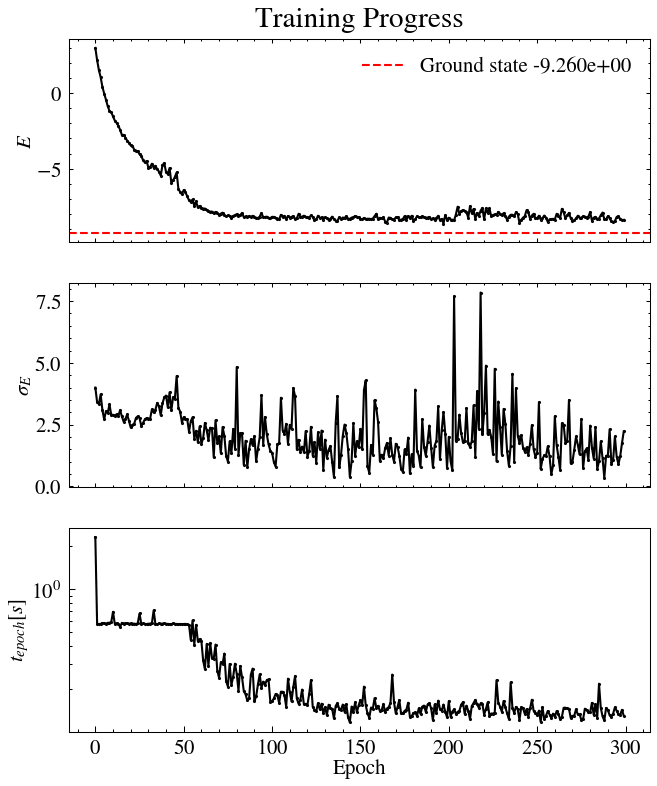

In [14]:
energies        = history
energies_std    = history_std
fig, ax         = Plotter.get_subplots(nrows=3, ncols=1, figsize=(5, 6), dpi=150, sharex=True)
Plotter.plot(ax[0], x=np.arange(len(energies)), y=np.real(energies), marker="o", markersize=0.5, lw=1)
if eigv is not None:
    ax[0].axhline(eigv[0], color='r', linestyle='--', label=f'Ground state {eigv[0]:.3e}')
    ax[0].legend()
Plotter.set_ax_params(ax[0], title="Training Progress", ylabel=r"$E$")
Plotter.set_tickparams(ax[0], maj_tick_l=2, min_tick_l=1)


Plotter.plot(ax[1], x=np.arange(len(energies_std)), y=np.real(energies_std), marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[1], ylabel=r"$\sigma_E$")
Plotter.set_tickparams(ax[1], maj_tick_l=2, min_tick_l=1)

Plotter.plot(ax[2], x=np.arange(len(epoch_times)), y=np.real(epoch_times), marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[2], xlabel="Epoch", ylabel=r"$t_{epoch} [s]$", yscale="log")